In [1]:
%matplotlib inline 
#widget
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [2]:
#Only for multicore runs
def simple_partition_function(coords, mpi_size=1):
    """A very simple partition function
    that assigns particles to processors
    """
    return np.linspace(0, mpi_size, coords.shape[0], endpoint=False, dtype=np.int32)

In [3]:
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
restart = 0
paths = path(0)
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
ds = xr.open_dataset('/home/jvalenti/projects/rrg-allen/jvalenti/Runs_alpha0220190101_.nc', decode_times=False)
dls = xr.open_dataset('/home/jvalenti/projects/rrg-allen/jvalenti/alpha02_run_restart20190201_.nc', decode_times=False)

In [5]:
DS=ds.to_dataframe()
DLS=dls.to_dataframe()

In [6]:
DS = DS.dropna()
DS = DS[DS.time>0]
DSb = DS[DS.status==2]
DSe = DS[DS.status==3]
DS = DS[DS.status==1]

In [7]:
DLS = DLS.dropna()
DLS = DLS[DLS.time>0]
DlSb = DLS[DLS.status==2]
DlSe = DLS[DLS.status==3]
DLS = DLS[DLS.status==1]

In [8]:
DSdeep = DS[DS.z>50]
DSshallow = DS[DS.z<800]

In [9]:
DSdep = DS[DS.z>50]
DSsall = DS[DS.z<800]
DSshal = DS[DS.z<50]

coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')


Text(0.5, 1.0, 'Deeper than 50 m')

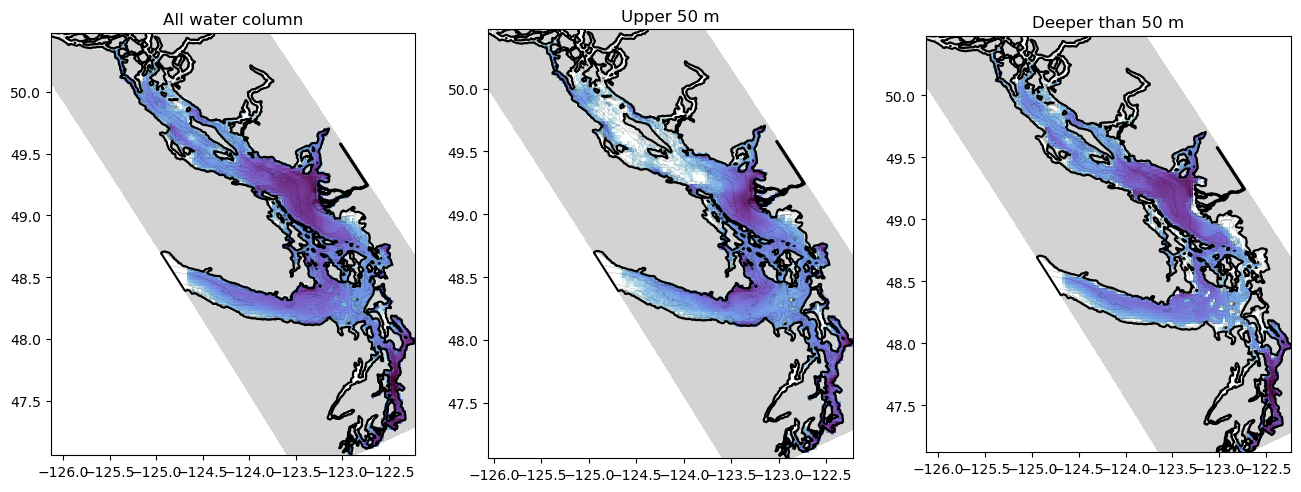

In [10]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,3,figsize=(16, 8))

ax[0].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[0].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[0].hist2d(DS.lon,DS.lat,150,norm = colors.LogNorm(),cmap =cm)
ax[0].set_aspect(1/np.sin(np.deg2rad(49)))
ax[0].set_title('All water column')

ax[1].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[1].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[1].hist2d(DSshal.lon,DSshal.lat,150,norm = colors.LogNorm(),cmap =cm)
ax[1].set_aspect(1/np.sin(np.deg2rad(49)))
ax[1].set_title('Upper 50 m')
#cb2=fig.colorbar(aa,ax=ax,pad=0.01)

ax[2].contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax[2].contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax[2].contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax[2].hist2d(DSdep.lon,DSdep.lat,150,norm = colors.LogNorm(),cmap =cm)
ax[2].set_aspect(1/np.sin(np.deg2rad(49)))
ax[2].set_title('Deeper than 50 m')


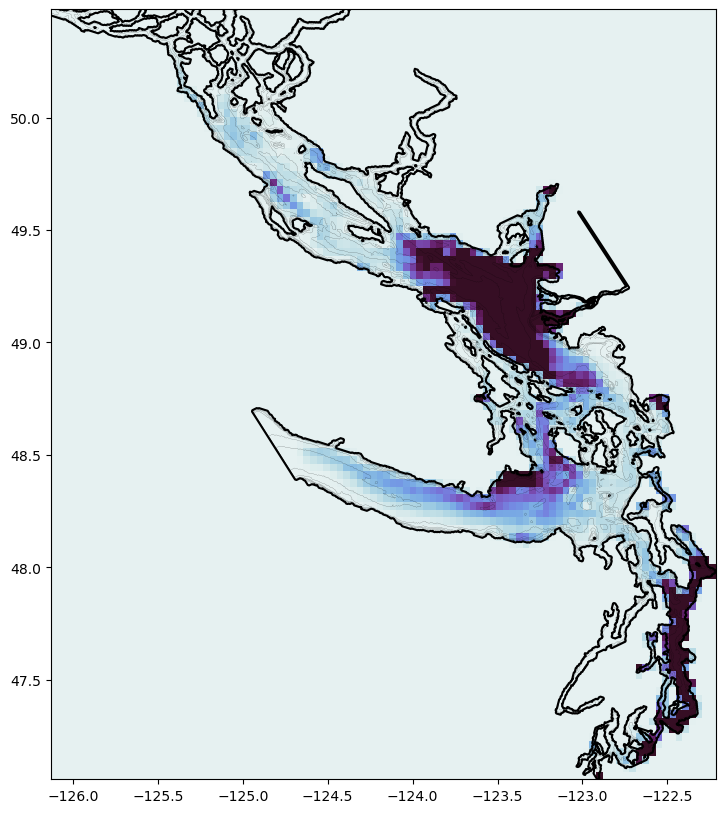

In [11]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(10, 10))

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax.hist2d(DS.lon,DS.lat,100,cmap =cm,vmin=1e-5,vmax=2000)
ax.set_aspect(1/np.sin(np.deg2rad(49)))

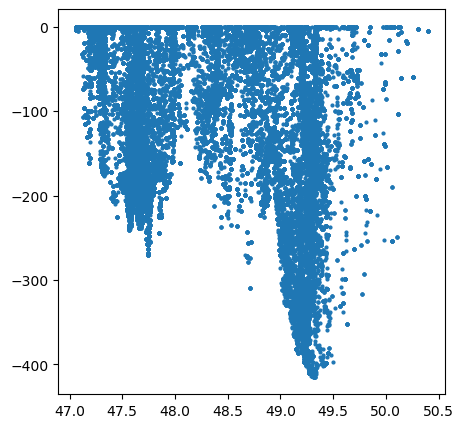

In [12]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

fig, ax = plt.subplots(1,1,figsize=(5, 5))

#ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
#ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = plt.scatter(ds.lat[:,-10:],-ds.z[:,-10:],s =4)
#ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [13]:
count = []
countb = []
counte = []
countl = []
countbl = []
countel = []
for i in range(62):
    times= DS.time.iloc[0]+i*12*3600
    count.append(len(DS[DS.time == times]))
    counte.append(len(DSe[DSe.time == times]))
    countb.append(len(DSb[DSb.time == times]))
for i in range(160):
    times= DLS.time.iloc[0]+i*12*3600
    countl.append(len(DLS[DLS.time == times]))
    countel.append(len(DlSe[DlSe.time == times]))
    countbl.append(len(DlSb[DlSb.time == times]))

In [14]:
count2 = [0] + count +countl[1:100]
countb2 =  [0] + countb +[i + countb[-1] for i in countbl[1:100]]
counte2 =  [0] + counte +[i + counte[-1] for i in countel[1:100]]

In [15]:
# def steady(a, b, N):
#     # a, b: exponential decay parameter
#     # N: number of samples 
#     return a * (1-b) ** np.arange(N)
# a = exponential_decay(count[0], 1/10, 60)

In [18]:
np.polyfit(x, np.log(sine), deg=1)

array([-0.09313375,  9.91434128])

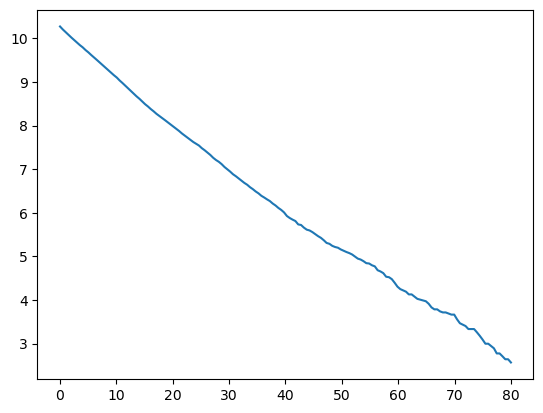

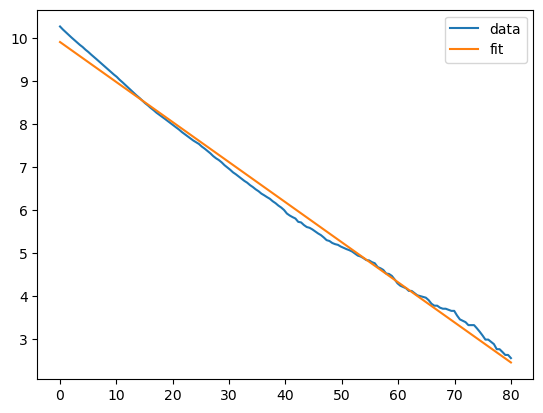

In [22]:
x = np.linspace(0,80,160)

sine = countl
plt.plot(x,np.log(sine))

poly = np.polyfit(x, np.log(sine), deg=1)

fig, ax = plt.subplots()
ax.plot(x,np.log(sine), label='data')
y = poly[1]+x*poly[0]
ax.plot(x,y, label='fit')
ax.legend()


(0.0, 100000.0)

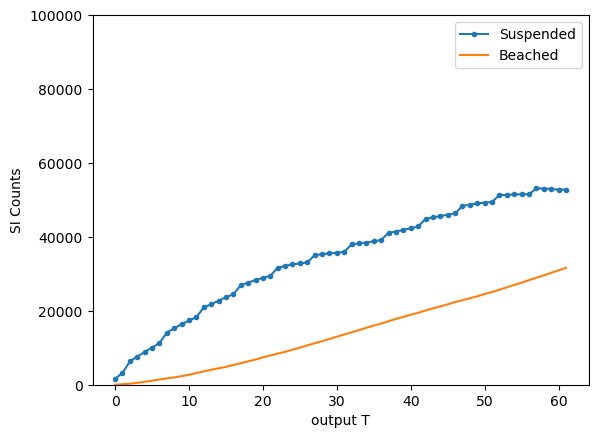

In [ ]:
plt.plot(count,'.-',label = 'Suspended')
plt.plot(countb,label = 'Beached')
#plt.plot(counte,label = 'Sediment')
plt.ylabel('SI Counts')
plt.xlabel('output T')
plt.legend()
plt.ylim([0,1e5])

(0.0, 100000.0)

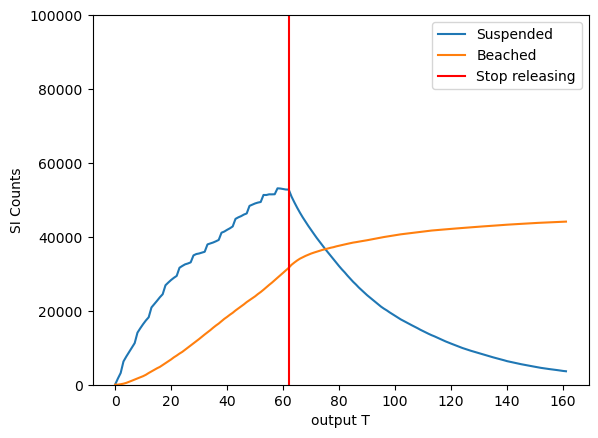

In [ ]:
plt.plot(count2,label = 'Suspended')
plt.plot(countb2,label = 'Beached')
#plt.plot(counte2,label = 'Sediment')
plt.axvline(x = 62,color='r',label ='Stop releasing')
plt.ylabel('SI Counts')
plt.xlabel('output T')
plt.legend()
plt.ylim([0,1e5])

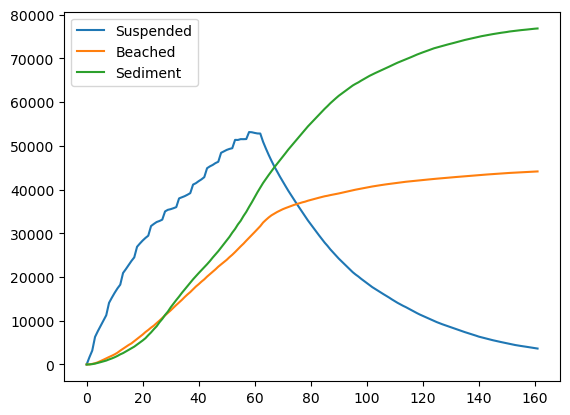

In [ ]:
plt.plot(count2,label = 'Suspended')
plt.plot(countb2,label = 'Beached')
plt.plot(counte2,label = 'Sediment')
plt.legend()

In [ ]:
path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [ ]:
def Conc_OP(outfile,t0):
    MFc=1e7
    coords=xr.open_dataset(paths['coords'],decode_times=False)
    ds = xr.open_dataset(outfile)
    DS=ds.to_dataframe()
    DS = DS.dropna()
    time = np.array(ds.time[0,:])
    time0 = time[t0]
    DS = DS[DS.time>time0]
    mask = xr.open_dataset(paths['mask'])
    conc=np.zeros((coords.nav_lon.shape[0],coords.nav_lon.shape[1],mask.gdepw_0.shape[1]))
    jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
    arr = mask.gdepw_0[0,:,240,340]
    dssla=np.array(DS.lat)
    dsslo=np.array(DS.lon)
    dsscon= float(MFc)
    dssdep=np.array(DS.z)
    dssvol=np.array(DS.cellvol)
    
    for i in range(len(DS)):
         if i%5000==0:
             print(f'{100*i/len(DS):.2f}% done.')
         jj = jjii.jj.sel(lats=dssla[i], lons=dsslo[i], method='nearest').item()
         ii = jjii.ii.sel(lats=dssla[i], lons=dsslo[i], method='nearest').item()
         try:
             dep = (np.abs(arr - dssdep[i])).argmin()
             if arr[dep] > dssdep[i]:
                 dep+=-1
             conc[jj,ii,dep] += dsscon/dssvol[i]
         except ValueError:
             print('error')
             pass
    return conc

In [ ]:
DS=ds.to_dataframe()
DS.dropna()
cellvol = np.array(1e7/DS.cellvol)

In [ ]:
import numpy as np

def count_coordinates_inside_cells(center_x_list, center_y_list, cell_width_list, cell_height_list, coordinates):
    coordinates = np.array(coordinates)
    x, y = coordinates[:, 0], coordinates[:, 1]

    min_x = center_x_list - cell_width_list / 2
    max_x = center_x_list + cell_width_list / 2
    min_y = center_y_list - cell_height_list / 2
    max_y = center_y_list + cell_height_list / 2

    inside_mask = np.logical_and.reduce([
        min_x[:, np.newaxis] <= x,
        x <= max_x[:, np.newaxis],
        min_y[:, np.newaxis] <= y,
        y <= max_y[:, np.newaxis]
    ])

    count_inside_cells = np.sum(inside_mask, axis=1)
    return count_inside_cells

# Example usage:
num_cells = 5
center_x_list = np.random.rand(num_cells) * 100
center_y_list = np.random.rand(num_cells) * 100
cell_width_list = np.random.rand(num_cells) * 10
cell_height_list = np.random.rand(num_cells) * 10

num_coordinates = 1000
coordinates_list = np.random.rand(num_coordinates, 2) * 100

counts = count_coordinates_inside_cells(center_x_list, center_y_list, cell_width_list, cell_height_list, coordinates_list)
print(f"Number of coordinates inside each cell: {counts}")

Number of coordinates inside each cell: [2 2 0 1 7]


In [ ]:
def coord_to_dec(coord):     
    deg = int(coord.split('°')[0])
    mins = float(coord.split('°')[1].split('’')[0])
    Dir = coord.split('°')[1].split('’')[1]
    if 'W' in Dir or 'S' in Dir:
        Dir = -1
    else:
        Dir = 1
    return Dir*(deg+(mins)/60)

Lat = ['49°43.60’ N','49°15.00’ N','49°12.62’ N','49°03.90’ N','48°18.00’ N']
Lon = ['124°40.80’ W','123°40.00’ W','123°18.00’ W','123°19.00’ W','124°00.00’ W']

Latd = []
Lond = []

for i in range(len(Lat)):
    Latd.append(coord_to_dec(Lat[i]))
    Lond.append(coord_to_dec(Lon[i]))

Latd += [49.98417997610155,48.542375452005125,48.45771096879191]
Lond += [-125.20012905559554,-123.23576134099453, -124.24787341557142]

In [ ]:

from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense
conc = np.load('/ocean/jvalenti/MOAD/concentration_31days.npy')
##ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
fig, ax = plt.subplots(1,1,figsize=(16, 10))
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax.contourf(coords.nav_lon, coords.nav_lat,np.sum(conc[:2,:,:],axis=0)/2,levels = np.linspace(1,50,12), extend='both')
aa.cmap.set_over('orange')
aa.cmap.set_under('white')
plt.colorbar(aa)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
ax.set_title('All time')

plt.plot(Lond[:5], Latd[:5],'r*',zorder=2)
#plt.plot(Lond[5:], Latd[5:],'b*',zorder=2)

FileNotFoundError: [Errno 2] No such file or directory: '/ocean/jvalenti/MOAD/concentration_31days.npy'

In [ ]:
time= np.array(DS.time[0,:])
countime = [] 
countime1 = [] 
countime2 = [] 
for t in time:
    countime.append(len(DScol.time[DScol.time==t]))
    countime1.append(len(DSsed.time[DSsed.time==t]))
    countime2.append(len(DSbe.time[DSbe.time==t]))

In [ ]:
lats = np.array(DS.lat)
vols=np.array(DS.cellvol)

lats[lats>47.5]

1355916

In [ ]:
# file = '/home/jvalenti/projects/rrg-allen/jvalenti/outfall_30days.nc'
# t0 = 109
# conc1 = Conc_OP(file,t0)

0.00% done.


KeyboardInterrupt: 

6490000000.0

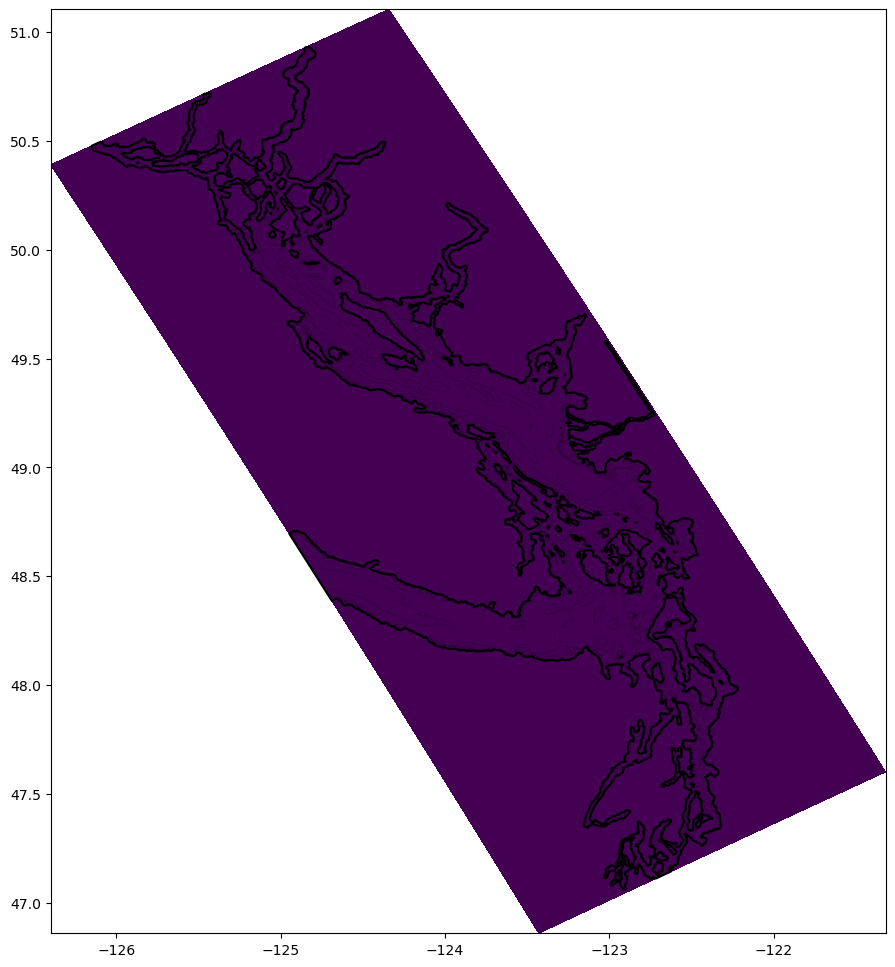

In [ ]:
X = mask.nav_lon
Y = mask.nav_lat
Z = np.sum(conc1[:,:,:],axis=2)
fig, ax = plt.subplots(figsize=(12, 12))
#ax.imshow(Z, origin='lower', interpolation='bicubic', aspect='auto',
                #extent=[X.min(), X.max(), Y.min(), Y.max()])
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.contourf(X,Y,Z,vmin=0,vmax = 1e8)
ax.set_aspect(1/np.sin(np.deg2rad(49)))

In [ ]:
timer = np.array(ds.time[0,:])
N0 = 109
time0 = timer[N0]
import time
start = time.time()
Dts = DS[DS.time>time0]
for ix in range(50):
     j,i = finder(Dts.lat.iloc[ix],Dts.lon.iloc[ix])
     conc[j,i] += 1e7/Dts.cellvol.iloc[ix]
end = time.time()
TE = (end - start)
len(Dts)*TE/(50)

1298.2663310337066

In [ ]:
# conc = np.zeros((898,398))
# Dts = DS[DS.time>time0]
# for ix in range(len(Dts)):
#     j,i = finder(Dts.lat.iloc[ix],Dts.lon.iloc[ix])
#     conc[j,i] += 1e7/Dts.cellvol.iloc[ix]

In [ ]:
# OOD = []
# MDD = []
# for i in range(len(lat)):
#     jj,ii=finder(lat[i],lon[i])
#     if z[i] > mask.totaldepth[jj,ii]:
#         print(f'outofdomain {lat[i]},{lon[i]}, depth max {mask.totaldepth[jj,ii].item()}')

In [ ]:
# from matplotlib import pyplot as plt, animation, rc,colors

# fig, ax = plt.subplots(1,1,figsize=(5, 5))

# ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
# ax.set_aspect(1/np.sin(np.deg2rad(49)))
# ax.set_xlim([-122.34307010375663-0.05,-122.34307010375663+0.05])
# ax.set_ylim([47.84938828396773-0.05,47.84938828396773+0.05])
# plt.scatter(-122.666879, 47.131004)
# plt.scatter(lon,lat,c='r') 